# Introduction

In [ ]:
#EXPLAIN PURPOSE OF RESEARCH & WHICH NETWORK MODELS WE USE

# Methodology

## Step 0: Installing Libaries

In [15]:
#NS Flash assignment 1

%pip install pandas networkx matplotlib seaborn numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [50]:
# Import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Step 1: Load & Clean White Helmets data

In [51]:
df = pd.read_csv('pairwise_52seconds_share.csv')
print(df.head())
print(df.info())

   id      videoID                  userID_1                  userID_2  \
0   0  -6bGXfM8-gs  19372991|840224732847833  19372991|840224732847833   
1  10  -fJbMWhkTAw    Ej8Mm0YMadzmx4osDA_hgg    Ej8Mm0YMadzmx4osDA_hgg   
2  11  -ilNuSh1Fgw    feNNP607aG1F64jR6bk8jw    CVEf5dB1MvNRTQFYivAIPQ   
3  12  -ilNuSh1Fgw    5SDVRa-J-_cWYP6g0WNzLw    jz6hyweGgVHGTw-PbEMqKw   
4  13  -ilNuSh1Fgw    42Egn_22OjOzg2XMqAa9_g    poH0yvIGbS5_7MdXM4EuRA   

           timestamp_1          timestamp_2  time_diff_seconds  
0  2018-07-22 21:19:58  2018-07-22 21:19:58                0.0  
1  2018-08-01 00:51:08  2018-08-01 00:51:08                0.0  
2  2018-04-27 22:28:49  2018-04-27 22:29:36               47.0  
3  2018-05-14 16:52:08  2018-05-14 16:52:24               16.0  
4  2018-05-14 16:55:04  2018-05-14 16:55:15               11.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471 entries, 0 to 4470
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------

In [52]:
#Rename column with missing title in csv:
df.rename(columns={'Unnamed: 0': 'edgeID'}, inplace=True)

# Check for missing values
print("\nMissing Values per column")
print(df.isnull().sum())

# Check for duplicate rows
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

# --- INVALID VALUES CHECKS ---

# 1. Time difference too large or negative
invalid_time_diff = df[(df['time_diff_seconds'] < 0.0) | (df['time_diff_seconds'] > 52.0)]
print(f"\nRows with invalid time differences: {len(invalid_time_diff)}")

# 2. Self-edges (user connected to itself)
same_user = df[df['userID_1'] == df['userID_2']]
print(f"Rows that connect edge to itself: {len(same_user)}")

# Remove self-edges
df = df[df['userID_1'] != df['userID_2']]
print(f"Remaining rows after removing self-edges: {len(df)}")

# 3. Edges with zero time difference (optional cleanup)
zero_time_diff = df[df['time_diff_seconds'] == 0.0]
print(f"Number of edges where time_diff_seconds is 0.0: {len(zero_time_diff)}")

# Show details for review
if len(zero_time_diff) > 0:
    print(zero_time_diff.head())

# Final dataframe info
print("\nDataFrame info after cleanup:")
print(df.info())



Missing Values per column
id                   0
videoID              0
userID_1             0
userID_2             0
timestamp_1          0
timestamp_2          0
time_diff_seconds    0
dtype: int64

Duplicate Rows: 0

Rows with invalid time differences: 0
Rows that connect edge to itself: 344
Remaining rows after removing self-edges: 4127
Number of edges where time_diff_seconds is 0.0: 14
        id      videoID                   userID_1                userID_2  \
161    260  2Jb_lpdNRU8    2572694|885420584986830  3QOONeDucvajwi1U1Y5Z7A   
206    310  3tIupmpY7IA  16548407|1821040977916389  LEb7CblKLJHjHCnmytR5UQ   
482    698  9gXHcOIhB7s     r73dGcK2Gcx8t6UNE1dRHA  GioWuAM9ufsQlV_-1mkHiw   
2501  2731  CLRsB_QJvkI     PMyrVtWQnGWB0QwsKS_NGw  uv3ZAO5Gd5HoRoPdQEywLQ   
3486  3878  OCrY6Q_qZUY    318216|2356029011082368  g6dCJe_oS3-vGq9WrCu6QQ   

              timestamp_1          timestamp_2  time_diff_seconds  
161   2018-08-01 03:00:00  2018-08-01 03:00:00                0.0  


## Step 2: Getting to know our data
### Look into #unique_users & #unique_videos

In [53]:
#Get the unique number of users in the dataset
find_unique_users = pd.unique(df[['userID_1', 'userID_2']].values.ravel())
unique_users = len(find_unique_users)
print(unique_users)

#Get the number of unique videos posted
unique_videos = len(df['videoID'].unique())
print(unique_videos)


4030
212


## Step 3: Build graphs for White Helmets data 
### Two graphs: (User <-> User, VideoID <-> User)

Number of Edges in User-User Graph: 4078


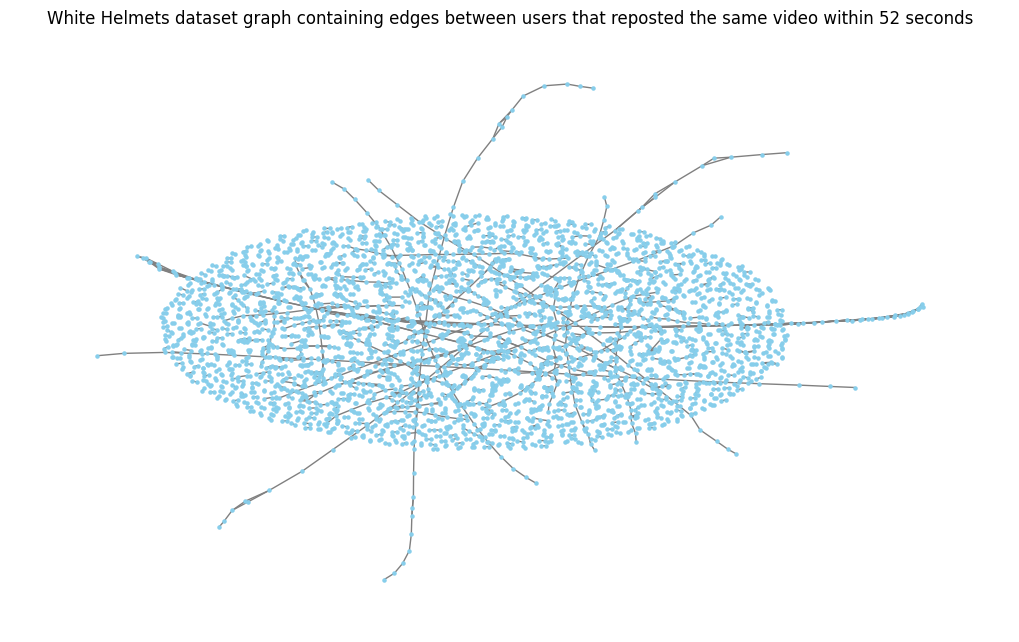

In [54]:
# Build weighted User-User Graph

edge_weights = (
    df.groupby(['userID_1', 'userID_2'])
    .size()
    .reset_index(name='weight')
)

User_graph = nx.from_pandas_edgelist( # Creating an edgelist from the dataframe
    edge_weights,
    source='userID_1', # Undirected network. Edges between users
    target='userID_2',
    edge_attr='weight',
    create_using=nx.Graph()
)

UserGraph_n_edges = User_graph.number_of_edges()
print(f"Number of Edges in User-User Graph:", UserGraph_n_edges)

plt.figure(figsize=(10, 6))
nx.draw(User_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title('White Helmets dataset graph containing edges between users that reposted the same video within 52 seconds')
plt.show()

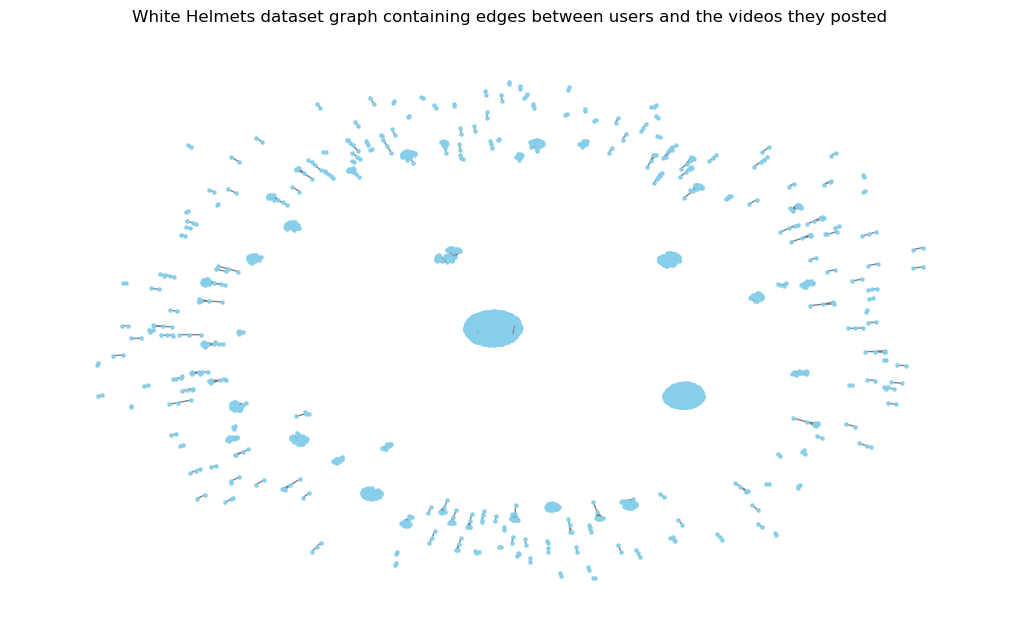

In [38]:
# Build VideoID-User1 Graph
edge_weights = df.groupby(['videoID', 'userID_1']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
VideoID_User1_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID_1',
    edge_attr='weight',
    create_using=nx.Graph()
)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User1_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title('White Helmets dataset graph containing edges between users and the videos they posted')
plt.show()


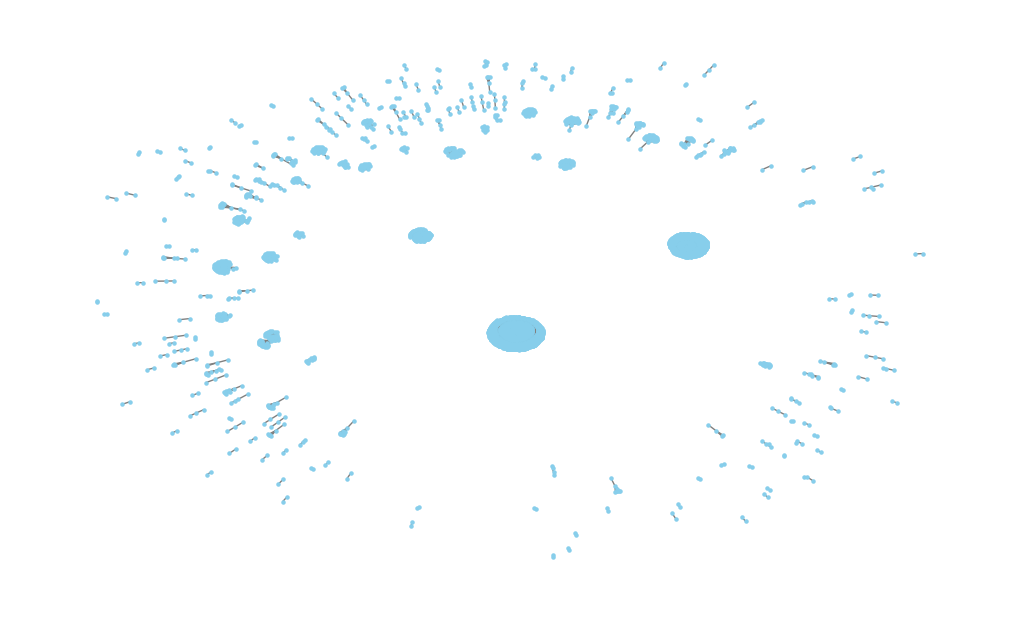

In [50]:
# Build VideoID-User2 Graph
edge_weights = df.groupby(['videoID', 'userID_2']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
VideoID_User2_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID_2',
    edge_attr='weight',
    create_using=nx.Graph()
)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User2_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.show()


Number of Edges in Video-User Graph: 4091


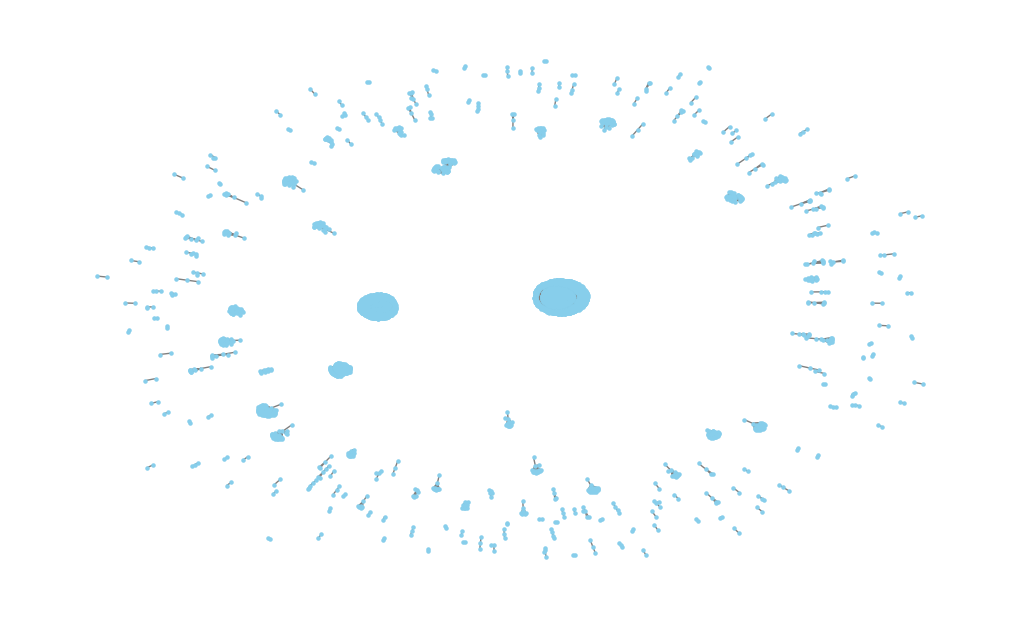

4030
212


In [121]:
# Merge graphs above to get User <-> Video graph:

# Melt the two user columns into one
user_video_pairs = pd.melt(
    df,
    id_vars=['videoID'],
    value_vars=['userID_1', 'userID_2'], #melt these two together
    var_name='user_type', #shows from which column the user came --> maybe we can remove this column as it might just add confusion
    value_name='userID' #name of the melted column
)

# Aggregate weights: shows the #interactions per user-video pair
edge_weights = user_video_pairs.groupby(['videoID', 'userID']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
video_user_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID',
    edge_attr='weight',
    create_using=nx.Graph()
)

UserVideoGraph_n_edges = video_user_graph.number_of_edges()
print(f"Number of Edges in Video-User Graph:", UserVideoGraph_n_edges)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User2_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.show()

# Check loss of instances (videos or users) --> outputs below give the same number so no loss of instances.
# Get the unique number of users in the dataset
find_unique_users_in_graph = pd.unique(user_video_pairs['userID'])
unique_users_in_UVgraph = len(find_unique_users_in_graph)
print(unique_users_in_UVgraph)

# Get the number of unique videos posted
unique_videos = len(user_video_pairs['videoID'].unique())
print(unique_videos)

Is bipartite: True


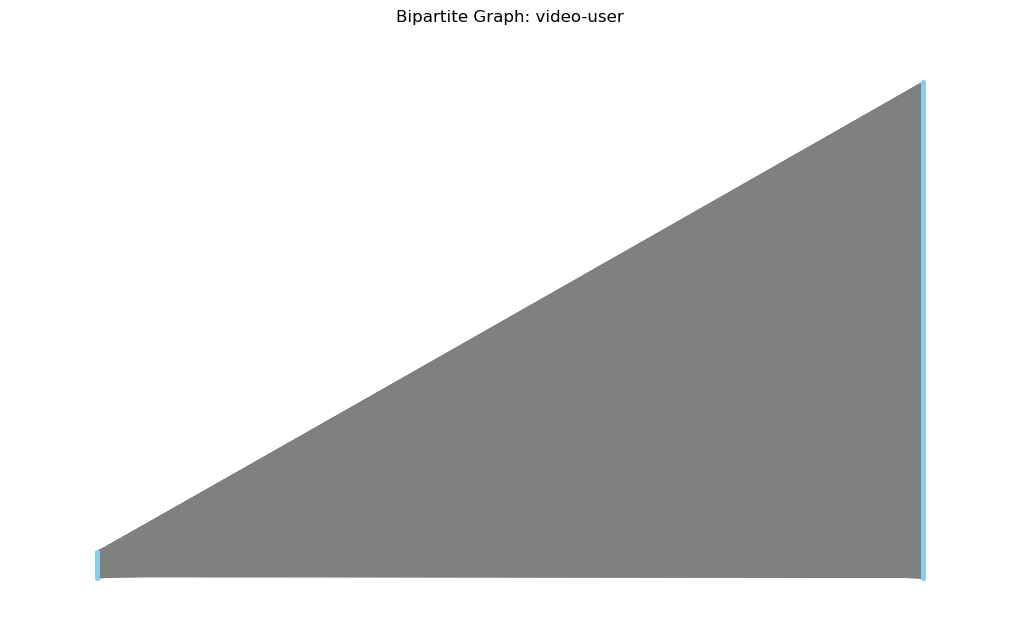

In [98]:
# Create the bipartite graph
video_user_graph = nx.Graph()
video_user_graph.add_nodes_from(edge_weights['videoID'].unique(), bipartite=0)  # videos
video_user_graph.add_nodes_from(edge_weights['userID'].unique(), bipartite=1)  # users

# Add weighted edges
for _, row in edge_weights.iterrows():
    video_user_graph.add_edge(row['userID'], row['videoID'], weight=row['weight'])

from networkx.algorithms import bipartite
is_bipartite = bipartite.is_bipartite(video_user_graph)
print(f"Is bipartite: {is_bipartite}")

# Get the node sets (helps position the two groups separately)
video_nodes = set(n for n, d in VideoID_User1_graph.nodes(data=True) if d['bipartite'] == 0)
user_nodes = set(video_user_graph) - video_nodes

# Define positions: one group left, one right
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(video_nodes))
pos.update((n, (2, i)) for i, n in enumerate(user_nodes))

plt.figure(figsize=(10, 6))
nx.draw(video_user_graph, pos=pos, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title("Bipartite visualization of Video-User")
plt.show()


## Step 4: Get Relevant Network Metrics

#### 1. Density

In [55]:
#density_User1 = nx.density(VideoID_User1_graph)
#density_User2 = nx.density(VideoID_User2_graph)
density_UserGraph = nx.density(User_graph)
density_UserVideoGraph = nx.density(video_user_graph)

print("Density:")
#print(f"VideoID–User1 Graph: {density_User1:.4f}")
#print(f"VideoID–User2 Graph: {density_User2:.4f}")
print(f"VideoID–UserID Graph: {density_UserVideoGraph:.4f}")
print(f"User1–User2 Graph:  {density_UserGraph:.4f}")


Density:
VideoID–UserID Graph: 0.0005
User1–User2 Graph:  0.0005


Justification of metric:
The density measure is normalized between 0 and 1, which allows for easy comparison between different networks. It gives an indicator of how sparse or dense a network is. If the density values of networks differ drastically, the rate of interaction in these networks will probably be very different. In our study, the density metric is not a measure that we will directly compare between the White Helmets dataset and different network models. Rather, we will match the density of our random networks with the density of the White Helmets dataset (0.0005) to ensure that not only the number of nodes but also the number of edges in the networks are similar. This should create a similar amount of interaction between nodes, which - using the other metrics below - allows us to investigate whether the White Helmets dataset is in accordance with the Watts-Strogatz or Barabasi-Albert model (or neither).

### 2. Node degree

In [111]:
#SHOW THE DISTRIBUTION

#FIND KEY PLAYERS WHOSE DEGREE > E.G. 10

'''
def find_key_players(pair): 
    ID, normalized_repost_value = pair
    if normalized_repost_value >= 0.1:
        return True  # keep pair in the dictionary
    else:
        return False  # filter pair out of the filtered dictionary
    
#deg_cent_User1 = nx.degree_centrality(VideoID_User1_graph)
#deg_cent_User2 = nx.degree_centrality(VideoID_User2_graph)
deg_cent_UserGraph = nx.degree_centrality(User_graph)
deg_cent_UserVideoGraph = nx.degree_centrality(video_user_graph)

key_players_UserGraph = dict(filter(find_key_players, deg_cent_UserGraph.items()))
key_players_UserVideoGraph = dict(filter(find_key_players, deg_cent_UserVideoGraph.items()))

print("Degree centrality (videoID: value):")
print(f"User1–User2 Graph:  {key_players_UserGraph}")
print(f"UserID–VideoID Graph:  {key_players_UserVideoGraph}")
'''

#ALSO CALC AVERAGE DEGREE?


Average degree:
VideoID–User1 Graph: 1.8905
VideoID–User2 Graph: 1.8905
VideoID–UserID Graph: 1.9288
User1–User2 Graph:  2.0238


Justification of metric: 
Node degree is a measure that allows us to understand the flow of a graph. By looking at the degree distribution we can identify the presence of any hubs or 'key players' in the networks and see whether the graphs follow an organic, scale-free pattern or not. It helps to avoid under- or overestimating the rate of interactions in the network.

For the different network families we expect a different nide degree distribution:
- For ER, we expect a Poisson distribution
- For WS, we expect a similar average degree but with local clusters
- For BA, we expect to see a few high-degree hubs

By filtering out the key players who have the highest node degree, we can look for these players in the graphs to see if they exhibit inorganic behaviors/conspire together.

### 3. Average Clustering Coefficient

In [56]:
avg_clustering_UserVideoGraph = nx.average_clustering(video_user_graph)
avg_clustering_UserGraph = nx.average_clustering(User_graph)

print("Average clustering coefficient:")
print(f"VideoID–UserID Graph: {avg_clustering_UserVideoGraph:.4f}")
print(f"User1–User2 Graph:  {avg_clustering_UserGraph:.4f}")


Average clustering coefficient:
VideoID–UserID Graph: 0.0000
User1–User2 Graph:  0.2998


Justification of metric: the clustering coefficient (CC) measures the degree to which nodes in a network tend to cluster together on a normalized scale of [0,1]. It can be used in social networks - together with graph visualization - to determine whether there exist social (sub)groups in a given network. This metric is only relevant for the User-User graph as the Video-User graph is a bipartite graph, which has a CC of 0. If we see a CC > 0 for the User-User graph, this suggests it is worth looking into these clusters to discover any distinct network patterns (e.g. agenda broadcasting). Clustering indicates an organic structure as we see this in many non-random networks.

- For ER, we expect low clustering as this models a random network
- For WS, we expect to see high clustering
- For BA, we expect moderate clustering 

### 4. Betweenness Centrality

In [57]:
#Outputs a dictionary with the betweenness centrality values for the nodes
#bet_cent_User1 = nx.betweenness_centrality(VideoID_User1_graph)
#bet_cent_User2 = nx.betweenness_centrality(VideoID_User2_graph)
bet_cent_UserVideoGraph = nx.betweenness_centrality(video_user_graph)
bet_cent_UserGraph = nx.betweenness_centrality(User_graph)

#SHOW DISTRIBUTION
#ALSO CALC MAX BETWEENNESS CENTRALITY?

print("Betweenness centrality:")
#print(f"VideoID–User1 Graph: {avg_betweenness_User1:.7f}")
#print(f"VideoID–User2 Graph: {avg_betweenness_User2:.7f}")
print(f"VideoID–UserID Graph: {avg_betweenness_UserVideoGraph:.7f}")
print(f"User1–User2 Graph:  {avg_betweenness_UserGraph:.7f}")


Betweenness centrality:


NameError: name 'avg_betweenness_UserVideoGraph' is not defined

Justification of metric: 
The betweenness centrality shows the importance of individual nodes in the network. It gives an idea of how centralized a network is and allows us to understand if there are indivudal nodes that control the information flow (in our case: video reposts). In organic networks, some nodes will have a more powerful position and control this information flow.

- For BA networks we expect bridging hubs that show high betweenness
- For ER and WS networks, we expect a more evenly distributed degree centrality

### 5. Degree Centrality

In [173]:
#SHOW DISTRIBUTION
#ALSO CALC MAX DEGREE CENTRALITY

Degree centrality (videoID: value):
User1–User2 Graph:  {}
UserID–VideoID Graph:  {'CCmN6X_7kn0': 0.4058005187455789, 'DPgOnD0n9uw': 0.1325159160575336}


Justification of metric: Degree centrality measures a node's importance based on the amount of connections (edges) it has. It thus highlights any potential "influencers" that may orchestrate the reposting of the White Helmets videos. As we have a weighted network, the degree centrality will differ from the node degree.

- For ER networks, degree centrality should follow a roughly uniform pattern
- For WS, there are no influencers meaning all nodes have a similar degree centrality
- For BA networks, we expect a few nodes to dominate due to the preferential attachment property

### 6. Average Shortest Path Length

In [181]:
def avg_shortest_path(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        largest_component = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_component)
        return nx.average_shortest_path_length(subgraph)

#avg_path_User1 = avg_shortest_path(VideoID_User1_graph)
#avg_path_User2 = avg_shortest_path(VideoID_User2_graph)
avg_path_UserVideoGraph = avg_shortest_path(video_user_graph)
avg_path_UserGraph = avg_shortest_path(User_graph)

print("Average shortest path length (of the largest connected component):")
#print(f"VideoID–User1 Graph: {avg_path_User1:.4f}")
#print(f"VideoID–User2 Graph: {avg_path_User2:.4f}")
print(f"UserID–VideoID Graph:  {avg_path_UserVideoGraph:.4f}")
print(f"User1–User2 Graph:  {avg_path_UserGraph:.4f}")


Average shortest path length (of the largest connected component):
UserID–VideoID Graph:  1.9988
User1–User2 Graph:  8.9026


Justification of metric:
The average shortest path length is good way to see how fast information can spread through a network. Especially in the case of the White Helmets dataset it is crucial to see how fast users can spread videos and therefore information to reach their goal. A shorter average shortest path indicates that very quickly and makes the network possibly very important.

### Step 5: Construct Watts Stogratz Graph

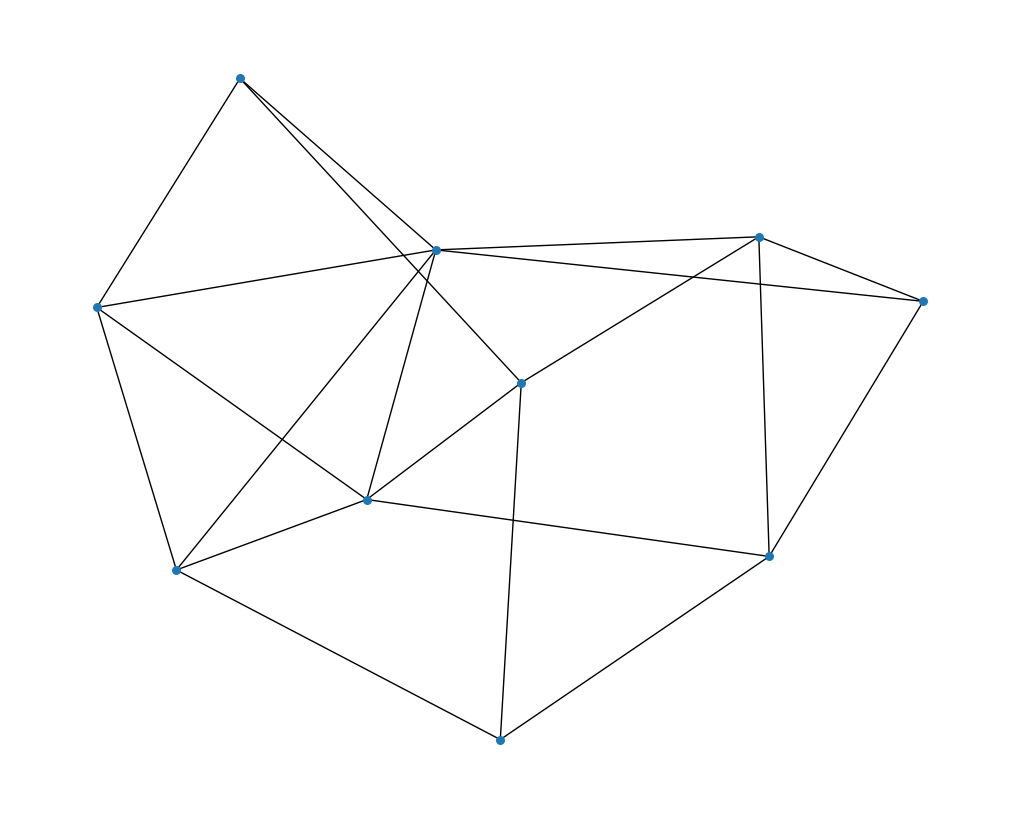

In [60]:
WS  = nx.watts_strogatz_graph(10, k=4, p=0.9, seed=None, create_using=None)
plt.figure(figsize=(10, 8))
nx.draw(WS, with_labels=False, node_size=30)
plt.show()

Justification of model: Watts Strogatz Graphs make it possible to generate graph with the same amount of nodes and a similar average degree compared to the White Helmet data set. These to attributes are very fundamental to a network and determine a lot of the shape of a network. Furthermore Watts Strogatz Graphs can recreate high clustering as it is seen in part of the White Helmet data set. Through the probability parameter the randomness of the network can be controlled. That makes this kind of graph very suitable to compare it against a real network to see if there are any inorganic patterns to be discovered.

### Step 6: Construct Barabási-Albert Graph

In [ ]:
UserGraph_n_nodes = User_graph.number_of_nodes()
UserGraph_n_edges = User_graph.number_of_edges()

# Create a Barabasi network with roughly the same amount of edges.
# -> Here, 1 edge per added node is a close approximation.
m_target = max(1, int(round(UserGraph_n_edges / UserGraph_n_nodes)))

BA = nx.barabasi_albert_graph(UserGraph_n_nodes, m_target, seed=42)

print("\n--- Comparison: Real User–User Graph vs Barabási–Albert Model ---\n")
print(f"Nodes: {UserGraph_n_nodes}")
print(f"Edges: {UserGraph_n_edges} (real) | {BA.number_of_edges()} (BA model)")

# --- Compare basic metrics ---
def graph_summary(G):
    G_u = G if not nx.is_directed(G) else G.to_undirected()
    n = G_u.number_of_nodes()
    degs = [d for _, d in G_u.degree()]
    avg_deg = sum(degs) / n if n > 0 else 0
    dens = nx.density(G_u)
    clust = nx.average_clustering(G_u)
    # Work on largest component for paths
    comps = list(nx.connected_components(G_u))
    largest = G_u.subgraph(max(comps, key=len))
    avg_path = nx.average_shortest_path_length(largest)
    return avg_deg, dens, clust, avg_path

avg_deg_real, dens_real, clust_real, path_real = graph_summary(User_graph)
avg_deg_ba, dens_ba, clust_ba, path_ba = graph_summary(BA)

print(f"Average degree: {avg_deg_real:.3f} (real) | {avg_deg_ba:.3f} (BA)")
print(f"Density: {dens_real:.6f} (real) | {dens_ba:.6f} (BA)")
print(f"Average clustering coefficient: {clust_real:.6f} (real) | {clust_ba:.6f} (BA)")
print(f"Average path length (largest component): {path_real:.3f} (real) | {path_ba:.3f} (BA)")

In [ ]:
# Plot meaningful distributions:

# Number of top nodes to compare
top_n = 20

# --- Centrality Calculations ---
eig_real = nx.eigenvector_centrality(User_graph, max_iter=2000)
eig_ba   = nx.eigenvector_centrality(BA, max_iter=2000)

close_real = nx.closeness_centrality(User_graph)
close_ba   = nx.closeness_centrality(BA)

deg_centrality_real = nx.degree_centrality(User_graph)
deg_centrality_ba   = nx.degree_centrality(BA)

betweenness_real = nx.betweenness_centrality(User_graph)
betweenness_ba   = nx.betweenness_centrality(BA)

# --- Compare top-n nodes for eigenvector centrality ---
def top_n_avg(centrality_dict, n=top_n):
    values_sorted = sorted(centrality_dict.values(), reverse=True)
    return np.mean(values_sorted[:n])

print(f"Average Eigenvector Centrality of top {top_n} nodes:")
print(f"Real: {top_n_avg(eig_real):.4f}, BA: {top_n_avg(eig_ba):.4f}")

# --- Average Closeness Centrality ---
print("Average Closeness Centrality:")
print(f"Real: {np.mean(list(close_real.values())):.4f}, BA: {np.mean(list(close_ba.values())):.4f}")

# --- Average Degree Centrality ---
print("Average Degree Centrality:")
print(f"Real: {np.mean(list(deg_centrality_real.values())):.4f}, BA: {np.mean(list(deg_centrality_ba.values())):.4f}")

# --- Average Betweenness Centrality ---
print("Average Betweenness Centrality:")
print(f"Real: {np.mean(list(betweenness_real.values())):.4f}, BA: {np.mean(list(betweenness_ba.values())):.4f}")

# --- Degree Distributions ---
deg_real = [d for _, d in User_graph.degree()]
deg_ba   = [d for _, d in BA.degree()]

plt.figure(figsize=(8,5))
plt.hist(deg_real, bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.title('Degree Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(deg_ba, bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.title('Degree Distribution: Barabási–Albert Model')
plt.show()

# --- Degree Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(deg_centrality_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Degree Centrality Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(deg_centrality_ba.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Degree Centrality Distribution: Barabási–Albert Model')
plt.show()

# --- Betweenness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(betweenness_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Density')
plt.title('Betweenness Centrality Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(betweenness_ba.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Density')
plt.title('Betweenness Centrality Distribution: Barabási–Albert Model')
plt.show()

# --- Closeness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(close_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Density')
plt.title('Closeness Centrality Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(close_ba.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Density')
plt.title('Closeness Centrality Distribution: Barabási–Albert Model')
plt.show()

# --- Eigenvector Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(eig_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Density')
plt.title('Eigenvector Centrality Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(eig_ba.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Density')
plt.title('Eigenvector Centrality Distribution: Barabási–Albert Model')
plt.show()


Justification of model:

Step 7 - Construct the

In [ ]:
# Construct the Erdős–Rényi graph to compare it to

n_nodes = User_graph.number_of_nodes()
n_edges = User_graph.number_of_edges()

# --- Create ER graph ---
# p = probability of edge creation in G(n, p)
p = n_edges / (n_nodes * (n_nodes - 1) / 2)
ER = nx.erdos_renyi_graph(n_nodes, p, seed=42)

# --- Function to compute summary metrics ---
def graph_summary(G):
    G_u = G if not nx.is_directed(G) else G.to_undirected()
    n = G_u.number_of_nodes()
    degs = [d for _, d in G_u.degree()]
    avg_deg = sum(degs) / n if n > 0 else 0
    dens = nx.density(G_u)
    clust = nx.average_clustering(G_u)
    comps = list(nx.connected_components(G_u))
    largest = G_u.subgraph(max(comps, key=len))
    avg_path = nx.average_shortest_path_length(largest)
    return avg_deg, dens, clust, avg_path

# --- Compare metrics ---
avg_deg_real, dens_real, clust_real, path_real = graph_summary(User_graph)
avg_deg_er, dens_er, clust_er, path_er = graph_summary(ER)

print("\n--- Comparison: Real User-User Graph vs Erdős–Rényi Model ---\n")
print(f"Nodes: {n_nodes}")
print(f"Edges: {n_edges} (real) | {ER.number_of_edges()} (ER model)")
print(f"Average degree: {avg_deg_real:.3f} (real) | {avg_deg_er:.3f} (ER)")
print(f"Density: {dens_real:.6f} (real) | {dens_er:.6f} (ER)")
print(f"Average clustering coefficient: {clust_real:.6f} (real) | {clust_er:.6f} (ER)")
print(f"Average path length (largest component): {path_real:.3f} (real) | {path_er:.3f} (ER)")


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# --- Centrality Calculations ---
top_n = 20

# Eigenvector Centrality
eig_real = nx.eigenvector_centrality(User_graph, max_iter=10000)
eig_er   = nx.eigenvector_centrality(ER, max_iter=10000)

# Closeness Centrality
close_real = nx.closeness_centrality(User_graph)
close_er   = nx.closeness_centrality(ER)

# Degree Centrality
deg_centrality_real = nx.degree_centrality(User_graph)
deg_centrality_er   = nx.degree_centrality(ER)

# Betweenness Centrality
betweenness_real = nx.betweenness_centrality(User_graph)
betweenness_er   = nx.betweenness_centrality(ER)

# --- Compare top-n Eigenvector Centrality ---
def top_n_avg(centrality_dict, n=top_n):
    values_sorted = sorted(centrality_dict.values(), reverse=True)
    return np.mean(values_sorted[:n])

print(f"Average Eigenvector Centrality of top {top_n} nodes:")
print(f"Real: {top_n_avg(eig_real):.4f}, ER: {top_n_avg(eig_er):.4f}")

# --- Average Closeness Centrality ---
print("Average Closeness Centrality:")
print(f"Real: {np.mean(list(close_real.values())):.4f}, ER: {np.mean(list(close_er.values())):.4f}")

# --- Average Degree Centrality ---
print("Average Degree Centrality:")
print(f"Real: {np.mean(list(deg_centrality_real.values())):.4f}, ER: {np.mean(list(deg_centrality_er.values())):.4f}")

# --- Average Betweenness Centrality ---
print("Average Betweenness Centrality:")
print(f"Real: {np.mean(list(betweenness_real.values())):.4f}, ER: {np.mean(list(betweenness_er.values())):.4f}")

# --- Degree Distribution ---
deg_real = [d for _, d in User_graph.degree()]
deg_er   = [d for _, d in ER.degree()]

plt.figure(figsize=(8,5))
plt.hist(deg_real, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(deg_er, bins=50, alpha=0.7, color='salmon')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution: ER Model')
plt.show()

# --- Degree Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(deg_centrality_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Degree Centrality: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(deg_centrality_er.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Degree Centrality: ER Model')
plt.show()

# --- Betweenness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(betweenness_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Density')
plt.title('Betweenness Centrality: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(betweenness_er.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Density')
plt.title('Betweenness Centrality: ER Model')
plt.show()

# --- Closeness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(close_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Density')
plt.title('Closeness Centrality: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(close_er.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Density')
plt.title('Closeness Centrality: ER Model')
plt.show()

# --- Eigenvector Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(eig_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Density')
plt.title('Eigenvector Centrality: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(eig_er.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Density')
plt.title('Eigenvector Centrality: ER Model')
plt.show()


### Step 7: Evaluation of the results

In [ ]:
'''
Patterns found in the network
--> see L1 (agenda broadcasting etc) & Daniel's findings
'''

### 1. Density

### 2. Node degree

### 3. Average Clustering Coefficient

In [ ]:
Our hypothesis is that people are more likely to repost videos from someone they know. Therefore, within the White Helmets organization where we assume they know one another all nodes should stick quite together. There may be tiny clusters within the organization as happens in large networks where subgroups of e.g. friends form. Given that we see a CC of +- 0.3 for the User-User Graph we think this to be the case. For the User-Video bipartite grapg the CC is 0 as expected.



### 4. Betweenness Centrality

### 5. Degree Centrality

### 6. Average Shortest Path Length

## Discussion